# iGED : Global Systems Dynamics Initiative

El objetivo principal de este documento es analizar las métricas globales en las siguientes redes capitales

  *  Ciudad Autónoma de Buenos Aires (CABA)
  *  Ciudad de México (CDMX)
  *  Santiago de Chile (SCL)
  *  Montevideo (MTV)
  *  Madrid (MAD)
  *  Sao Paulo (SAO)

y obtener un tidy DataFrame, para continuar analizando los datos obtenidos, por ejemplo obteniendo correlaciones entre parejas de métricas.

Respecto al notebook anterior, utilizamos la documentación de NetworkX: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

así como el siguiente recurso: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

para saber con cuáles métricas globales seguir estudiando nuestros ecosistemas.

In [1]:
#-------------------------------------------------------
# Importar paquetes a utilizar
#-------------------------------------------------------
import pandas as pd
import numpy as np 
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

G={}

for i in range(60):
    G[i]=nx.read_graphml('Random_Graphs/Random_Graph_'+str(i+1)+'.graphml')


In [2]:
#--------------------------------
# Central point of Dominance
#--------------------------------


def central_point_dominance(G):
    betwennesses = nx.betweenness_centrality(G)
    b_max = max(betwennesses.values())
    N = len(betwennesses.keys())
    count = 0
    for i, b_i in betwennesses.items():
        count += ( b_max - b_i )/(N-1)
    return count

In [3]:
#--------------------------------
# Spectral Radius
#--------------------------------
#     the smaller the spectral radius rho, the higher the probability of 'virus infection' tau, 
#     the more difficult it is for an idea to spread in the innovative network, 
#     namely, the less efficient

import numpy.linalg

def spectral_radius(G):
    L = nx.normalized_laplacian_matrix(G)
    e = numpy.linalg.eigvals(L.A)
    e_abs = [abs(x) for x in e]
    return max(e_abs)

In [4]:
def core_ratio(G):
    return len(nx.k_core(G,k=2).nodes())/len(G.nodes())

In [5]:
def rich_club_coeffs(G):
    t_ok = True
    t = 0
    d = dict()
    while t_ok:
        nodes_large_degree=[]
        for x in G.nodes():
            if G.degree(x)>t:
                nodes_large_degree.append(x)
        core = G.subgraph(nodes_large_degree)
        edges_core = len(core.edges())
        nodes_core = len(core.nodes())
        if nodes_core<=1:
            t_ok = False
            break
        d[t] = (2*edges_core)/(nodes_core*(nodes_core-1))
        t += 1 
    return d        

def max_rich_club(G):
    #rich_club_1=nx.algorithms.rich_club_coefficient(G, normalized=False)
    rich_club=rich_club_coeffs(G)
    max_i=0
    for i in range(len(rich_club)):
        if rich_club[i]>rich_club[max_i]:
            max_i=i
        else:
            return rich_club[max_i]

In [20]:
def eccentricity(G):
    excentricidades=nx.algorithms.distance_measures.eccentricity(G)
    excentricidad=0
    for i in excentricidades.keys():
        excentricidad+=excentricidades[i]
    return excentricidad/len(excentricidades.keys())

## Creacion del Dataframe

El siguiente bloque crea todas las metricas de la grafica que usaremos para estudiarlas.

In [51]:
n=len(G)

degree = n*[0]
diameter = n*[0]
radius = n*[0]
avg_shortest_path_length = n*[0]
transitivity = n*[0]
global_efficiency = n*[0]
modularity = n*[0]
rich_club_coefficient = n*[0]
core_rate= n*[0]
central_pt = n*[0]
spectral_radii = n*[0]
excentricidad = n*[0]
modularidad=n*[0]

for index in G.keys():
    graph=G[index]
    
    #conseguimos cada parámetro para esta ciudad
    degree[index]=                        2*len(graph.edges())/len(graph.nodes())
    diameter[index] =                     nx.diameter(graph)
    radius[index] =                       nx.radius(graph)
    avg_shortest_path_length[index] =     nx.average_shortest_path_length(graph)
    transitivity[index] =                 nx.transitivity(graph)
    global_efficiency[index] =            nx.global_efficiency(graph)
    #modularidad precomputada
    rich_club_coefficient[index] =        max_rich_club(graph)  
    core_rate[index]=                     core_ratio(graph)
    central_pt[index]=                    central_point_dominance(graph)
    spectral_radii[index]=                spectral_radius(graph)
    excentricidad[index]=                 eccentricity(graph)
    modularidad[index]=                   nx.algorithms.community.quality.performance(graph,nx.algorithms.community.modularity_max.greedy_modularity_communities(graph))

df=pd.DataFrame()


df['Eficiencia Global'] = global_efficiency
df['Degree']= degree
df['Transitividad'] = transitivity
df['Modularidad'] = modularidad
df['Excentricidad']= excentricidad
df['Radio'] = radius
df['Rich Club Coefficient'] = rich_club_coefficient
df['Core Ratio'] = core_rate
df['Central Point Dominance'] = [round(central_pt[index],3) for index in range(n)]
df['Spectral radius'] = [round(spectral_radii[index],3) for index in range(n)]
df['Camino más corto promedio'] = avg_shortest_path_length
df['Diámetro'] = diameter


## Colaboracion

Empezamos analizando las metricas que ya hemos calculado y luego usaremos esta informacion para crear una medida de la colaboracion.

In [52]:
#---------------------------------------------
#Preparar escalas y herramientas para el analisis.
#---------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X=df.to_numpy()



#normalized= StandardScaler().fit_transform(X)
pca=PCA(n_components=5)
prin_comp=pca.fit_transform(X)

pca.components_

array([[ 0.02368363, -0.25305316,  0.01299442, -0.0161432 , -0.31343466,
        -0.54036425,  0.01556938, -0.03967146,  0.05866092, -0.00350904,
        -0.15399244, -0.71816127],
       [ 0.00895109, -0.48973113, -0.00225761, -0.01129218, -0.04605719,
         0.77887261,  0.01144692, -0.01143393,  0.05489789,  0.01357485,
        -0.01672611, -0.38398867],
       [ 0.0187043 , -0.79156839,  0.01641002, -0.01865542, -0.07255627,
        -0.25223328,  0.01885338, -0.09034348,  0.09892042,  0.03475733,
        -0.06510966,  0.52897666],
       [ 0.08751013,  0.2209762 ,  0.03373636, -0.07278166, -0.68016435,
         0.18359678,  0.05202346,  0.06791932,  0.16770859, -0.02210354,
        -0.59521476,  0.22478889],
       [-0.05780381,  0.09403497,  0.0817445 , -0.016493  , -0.49383307,
         0.05773732, -0.01203858, -0.6254354 , -0.02718477,  0.19733082,
         0.54763184,  0.05257184]])

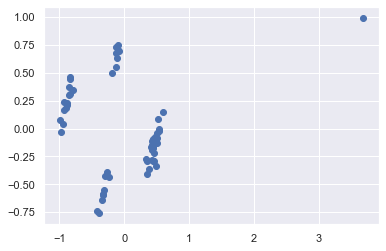

In [53]:
from matplotlib import pyplot as plt
plt.scatter(prin_comp[:,0], prin_comp[:,1],color='b')

In [69]:
#---------------------------------------
# Fórmula para colaboratividad
#---------------------------------------

eg = df['Eficiencia Global'].tolist()
tr = df['Transitividad'].tolist()
comunicacion = [eg[x]+tr[x] for x in range(n)]

r= df['Radio'].tolist()
sr= df['Spectral radius'].tolist()
size=[-r[x]/28-sr[x]/5 for x in range(n)]

rcc = df['Rich Club Coefficient'].tolist()
cr = df['Core Ratio'].tolist()
preparacion = [(rcc[x]+cr[x])/2 for x in range(n)]

colab_1 = [comunicacion[x]+preparacion[x]+size[x] for x in range(n)]
max_colab_1=[]
for i in range(len(colab_1)):
    if colab_1[i]>.3:
        print(colab_1[i],i)
        max_colab_1.append(i)

0.37690179386163175 1
0.3597402217366625 3
0.5528144640202921 5
0.34338953128456035 7
0.3062623515785765 9
0.3503928037593445 11
0.37604290803886914 12
0.30343928829434 14
0.31525510659926786 20
0.31849032882558276 22
0.3152434448828492 24
0.35362198166544695 25
0.33932376663125147 35
0.3083192984208191 42
0.33411452073991166 43
0.30541865146108127 44
0.32773420963481353 49
0.3085660196139893 50
0.3507023717052769 52
0.31919892275827966 53
0.33159827363997996 58


In [73]:
#Bad number between 11 and 35 is higher than 36 to 60

eg = df['Eficiencia Global'].tolist()
tr = df['Transitividad'].tolist()
comunicacion = [eg[x]+tr[x] for x in range(n)]

r= df['Radio'].tolist()
sr= df['Spectral radius'].tolist()
size=[-r[x]/28-sr[x]/5 for x in range(n)]

rcc = df['Rich Club Coefficient'].tolist()
cr = df['Core Ratio'].tolist()
preparacion = [(rcc[x]+cr[x])/2 for x in range(n)]

colab_1 = [((comunicacion[x]**2+preparacion[x]**2+size[x]**2)/3)**(1/2) for x in range(n)]
max_colab_1b=[]
for i in range(len(colab_1b)):
    if colab_1b[i]>.43:
        print(colab_1b[i],i)
        max_colab_1b.append(i)

0.4335028076424266 0
0.43753176761336443 1
0.43149924355746627 3
0.5043622869551668 5
0.4455468178699993 8
0.43126561622638704 10
0.433730287925361 11
0.4326648703799853 12
0.43959562345749187 17
0.4364438432023845 18
0.43324006965323153 19
0.43684909805376115 21
0.4339609223538563 27
0.43355979850012616 31
0.431009608372572 32
0.43058956195798115 37
0.4363704225421378 44
0.4509555732886308 53


In [68]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

rcc= df['Rich Club Coefficient'].tolist()
mod= df['Modularidad'].tolist()
futuro=[(rcc[x]+1-mod[x])/2 for x in range(n)]

tr = df['Transitividad'].tolist()
resistencia = [tr[x] for x in range(n)]

colab_2 = [((comunicacion[x]**2+futuro[x]**2+resistencia[x]**2)/3)**(1/2) for x in range(n)]
max_colab_2=[]
for i in range(len(colab_2)):
    if colab_2[i]>.21:
        print(colab_2[i],i)
        max_colab_2.append(i)

0.22830056621726855 1
0.21003267662269107 2
0.21690363477256727 3
0.21047463074125325 4
0.3398934850901574 5
0.2177823912300705 7
0.2103616370330609 8
0.2160883361378501 11
0.21956453322465674 12
0.21520719075676395 20
0.2203280966830905 25
0.21203445959972195 35
0.21543777691504476 36
0.21423168975620852 39
0.21768971688629038 43
0.22201918051954592 49
0.22024968479074772 52
0.2176678200945896 53
0.2140960744018184 58


In [76]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Core Ratio'].tolist()
md= df['Modularidad'].tolist()
preparacion = [1-(rcc[x]/2+md[x]/2) for x in range(n)]

colab_3 = [comunicacion[x]+preparacion[x]+size[x] for x in range(n)]
max_colab_3=[]
for i in range(len(colab_3)):
    if colab_3[i]>.67:
        print(colab_3[i],i)
        max_colab_3.append(i)

0.6854215507005375 1
0.7008895065150914 4
1.1006861727037653 5
0.6828792036031921 7
0.6957583970652077 13
0.6848731420259988 20
0.6713298055488807 25
0.7490891371834657 36
0.7160498126265097 39
0.7004154842924882 43
0.7145626650580623 49
0.6854451581677711 51
0.6704796708289175 52
0.6756822964306508 53
0.6987255448428292 55
0.671492843979964 57


In [81]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Core Ratio'].tolist()
md= df['Modularidad'].tolist()
preparacion = [1-(rcc[x]/2+md[x]/2) for x in range(n)]

colab_3 = [((comunicacion[x]**2+preparacion[x]**2+size[x]**2)/3)**(1/2) for x in range(n)]
max_colab_3=[]
for i in range(len(colab_3)):
    if colab_3[i]>.245:
        print(colab_3[i],i)
        max_colab_3.append(i)

0.2550556581055234 1
0.24706865880661183 2
0.2543080371451285 4
0.3956886252668821 5
0.2500967476692722 7
0.25394989285233 13
0.2506953428856495 20
0.2498187722258049 25
0.2671421293242758 36
0.24590590394876655 38
0.2607765994678477 39
0.2477081883566307 40
0.2539638055830213 43
0.2601267127369639 49
0.25001837989975473 51
0.2491294286020056 52
0.24583389007303758 53
0.2511668502785238 55
0.2466972066827345 57
